In [2]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [3]:
import os
import requests
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# Function to download a single image
def download_image(url, folder):
    try:
        img_data = requests.get(url).content
        img_name = url.split("/")[-1]
        img_path = os.path.join(folder, img_name)
        with open(img_path, 'wb') as handler:
            handler.write(img_data)
        print(f"Downloaded: {img_name}")
    except Exception as e:
        print(f"Failed to download {url}: {e}")

# Function to download images with controlled threads
def download_images_with_threads(image_urls, folder, max_workers=5):
    if not os.path.exists(folder):
        os.makedirs(folder)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for url in image_urls:
            executor.submit(download_image, url, folder)

# Function to remove duplicate images
def remove_duplicates(folder):
    seen_files = set()
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if filename in seen_files:
            os.remove(file_path)
            print(f"Removed duplicate: {filename}")
        else:
            seen_files.add(filename)

# Load the sample_test.csv file into a DataFrame
sample_test_df = pd.read_csv('dataset/sample_test.csv')

# Extract image URLs from the DataFrame
image_urls = sample_test_df['image_link'].tolist()

# Download images with limited threads (e.g., 5 threads)
download_images_with_threads(image_urls, 'sample_images/', max_workers=5)

# Remove duplicates
remove_duplicates('sample_images/')


Downloaded: 417SThj+SrL.jpg
Downloaded: 417SThj+SrL.jpg
Downloaded: 417NJrPEk+L.jpg
Downloaded: 41-NCxNuBxL.jpg
Downloaded: 41-NCxNuBxL.jpg
Downloaded: 41o3iis9E7L.jpg
Downloaded: 41nblnEkJ3L.jpg
Downloaded: 41ADVPQgZOL.jpg
Downloaded: 41nblnEkJ3L.jpg
Downloaded: 41pvwR9GbaL.jpg
Downloaded: 41ygXRvf8lL.jpg
Downloaded: 41zgjN+zW3L.jpg
Downloaded: 41ygXRvf8lL.jpg
Downloaded: 41uwo4PVnuL.jpg
Downloaded: 41uwo4PVnuL.jpg
Downloaded: 51+oHGvSvuL.jpg
Downloaded: 51-WIOx5pxL.jpg
Downloaded: 51-WIOx5pxL.jpg
Downloaded: 51+oHGvSvuL.jpg
Downloaded: 510xYFNYQ8L.jpg
Downloaded: 510xYFNYQ8L.jpg
Downloaded: 510xYFNYQ8L.jpg
Downloaded: 514bY8c4ZIL.jpg
Downloaded: 514pScQdlCL.jpg
Downloaded: 514bY8c4ZIL.jpg
Downloaded: 514pScQdlCL.jpg
Downloaded: 51BEuVR4ZzL.jpg
Downloaded: 51EBBqNOJ1L.jpg
Downloaded: 51BEuVR4ZzL.jpg
Downloaded: 51EBBqNOJ1L.jpg
Downloaded: 51EBBqNOJ1L.jpg
Downloaded: 51FSlaVlejL.jpg
Downloaded: 51KykmLgc0L.jpg
Downloaded: 51H+mX2Wk7L.jpg
Downloaded: 51H+mX2Wk7L.jpg
Downloaded: 51Su6zXk

In [4]:
import cv2
import pytesseract

def preprocess_image(image_path):
    # Load image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply thresholding
    _, thresh = cv2.threshold(blur, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    return thresh

def extract_text(image_path):
    processed_image = preprocess_image(image_path)
    
    # Run Tesseract OCR
    text = pytesseract.image_to_string(processed_image)
    return text

# Example usage
image_path = 'sample_images/41-NCxNuBxL.jpg'
extracted_text = extract_text(image_path)
print(extracted_text)


20CM

15C




In [5]:

from fuzzywuzzy import fuzz

# Example of flexible string matching
def find_match(extracted_text, keywords):
    # keywords could be a list of target units (e.g., cm, inch, lbs)
    for keyword in keywords:
        if fuzz.partial_ratio(extracted_text, keyword) > 80:  # threshold can be adjusted
            return keyword
    return None

# Example usage
keywords = ['cm', 'inch', 'lbs', 'mm']
extracted_text = "Found match: 12 inch"
matched_unit = find_match(extracted_text, keywords)
print(matched_unit)


inch


C:\Users\Hari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:
def normalize_units(extracted_text):
    # Dictionary of variations to standard units
    unit_dict = {
        'cm': 'centimeter',
        'mm': 'millimeter',
        'inch': 'inch',
        'lbs': 'pound'
    }
    
    for key, value in unit_dict.items():
        extracted_text = extracted_text.replace(key, value)
    
    return extracted_text

# Example usage
extracted_text = "Found match: 12 inch"
normalized_text = normalize_units(extracted_text)
print(normalized_text)  # Output: "Found match: 12 inch"


Found match: 12 inch


In [7]:
import re

def filter_relevant_data(extracted_text):
    # Regex to match numeric values with units (e.g., 12 cm, 3.5 inch)
    matches = re.findall(r'(\d+(\.\d+)?)\s?(cm|inch|mm|lbs)', extracted_text)
    return matches

# Example usage
extracted_text = "Blade Diameter 05am Rated input Power 2100w Max Cutting Capacity: 6 HD Wisoam Found match: 29 cm"
filtered_data = filter_relevant_data(extracted_text)
print(filtered_data)  # Output: [('29', '', 'cm')]


[('29', '', 'cm')]


In [8]:
def handle_edge_case(extracted_text):
    if not extracted_text:
        return "No relevant data found"
    return extracted_text

# Example usage
extracted_text = ""
result = handle_edge_case(extracted_text)
print(result)  # Output: "No relevant data found"


No relevant data found


In [9]:
df = pd.read_csv('dataset/test_out.csv')

# Display the contents
print(df)

    index prediction
0       0       20cm
1       1       20cm
2       2        NaN
3       3        NaN
4       4        NaN
..    ...        ...
83     83        NaN
84     84        NaN
85     85        NaN
86     86        NaN
87     87        NaN

[88 rows x 2 columns]


In [10]:
# Check the column names in the DataFrame
print(df.columns)


Index(['index', 'prediction'], dtype='object')


In [11]:
# Filter out rows where 'prediction' column is NaN
filtered_df = df.dropna(subset=['prediction'])

# Save the filtered results to a CSV file
filtered_df.to_csv('filtered_test_out.csv', index=False)

# Display the filtered results
print(filtered_df.head())


    index prediction
0       0       20cm
1       1       20cm
12     12       50cm
13     13       50cm
14     14   6.75 lbs


In [12]:
import os

# Get current working directory
cwd = os.getcwd()

# Print the directory
print(cwd)


d:\student_resource 3


In [13]:
# Check the first few predictions
print(df['prediction'].head(20))


0          20cm
1          20cm
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12         50cm
13         50cm
14     6.75 lbs
15          NaN
16          NaN
17    16cm 24cm
18    16cm 24cm
19          NaN
Name: prediction, dtype: object


In [14]:
unit_mapping = {
    'cm': 'centimetre',
    'mm': 'millimetre',
    'inch': 'inch',
    'lbs': 'pound',
    'kg': 'kilogram',
    'gram': 'gram',
    'ounce': 'ounce'
}

# Function to normalize the prediction
def normalize_prediction(prediction):
    # Check if the prediction is empty
    if not prediction:
        return ""
    
    # Extract numeric value and unit using regex
    match = re.match(r"(\d+\.?\d*)\s*(\w+)", prediction)
    if match:
        number, unit = match.groups()
        
        # Convert the unit to its full form using unit_mapping
        unit = unit_mapping.get(unit, unit)
        
        # Ensure there's a space between number and unit and format the number as a float
        return f"{float(number)} {unit}"
    
    # Return the original prediction if no match is found
    return prediction

# Load your filtered_test_out.csv
df = pd.read_csv('filtered_test_out.csv')

# Apply normalization to the 'prediction' column
df['prediction'] = df['prediction'].apply(normalize_prediction)

# Save the normalized predictions to a new CSV file
df[['index', 'prediction']].to_csv('filtered_normalized_test_out.csv', index=False)

print("Normalized predictions saved to filtered_normalized_test_out.csv")

Normalized predictions saved to filtered_normalized_test_out.csv


In [15]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set model to evaluation mode


C:\Users\Hari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [16]:
from PIL import Image

def preprocess_image_for_rcnn(image_path):
    # Load the image
    img = Image.open(image_path).convert("RGB")
    
    # Apply necessary transforms (resize, to tensor, normalize)
    img_tensor = F.to_tensor(img)
    return img_tensor


In [17]:
def get_rois(image_path):
    # Preprocess the image
    img_tensor = preprocess_image_for_rcnn(image_path)
    
    # Perform object detection
    with torch.no_grad():
        predictions = model([img_tensor])
    
    # Extract bounding boxes from predictions
    boxes = predictions[0]['boxes'].cpu().numpy()
    return boxes


In [18]:
def crop_and_extract_text(image_path, boxes):
    img = cv2.imread(image_path)
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        roi = img[y1:y2, x1:x2]
        
        # Apply OCR to the cropped region
        text = pytesseract.image_to_string(roi)
        print(f"Extracted text: {text}")


In [19]:
# Example code to clean image name from URL
sample_test_df['image_name'] = sample_test_df['image_link'].apply(lambda x: x.split("/")[-1].split(",")[0])


In [20]:
import os
from PIL import UnidentifiedImageError

def process_image_with_rcnn(image_path):
    try:
        if os.path.exists(image_path):
            boxes = get_rois(image_path)
            crop_and_extract_text(image_path, boxes)
        else:
            print(f"Image not found: {image_path}")
    except UnidentifiedImageError:
        print(f"Invalid image file: {image_path}")


In [21]:
import os

# Define the folder where your images are located
folder = 'sample_images/'  # Update with the correct path to your image folder

valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Process each image in the folder
for img_name in os.listdir(folder):
    if img_name.lower().endswith(valid_extensions):
        img_path = os.path.join(folder, img_name)
        process_image_with_rcnn(img_path)  # Call your RCNN function for object detection
    else:
        print(f"Skipping non-image file: {img_name}")



Extracted text: 
Extracted text: 
Extracted text: 20CM


Extracted text: 
Extracted text: 
Extracted text: ee we et


Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 20CM


Extracted text: 
Extracted text: 
Extracted text: ee we et


Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: “o2”


Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: “o2”


Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: Ab

Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: =
cr

|

=>

Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: 
Extracted text: =
cr

|

=>

Extracted text: 
Extracted t

In [22]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import torchvision.transforms as T

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

def detect_objects(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image)

    # Detect objects
    with torch.no_grad():
        predictions = model([image_tensor])

    # Extract bounding boxes of detected ROIs
    boxes = predictions[0]['boxes'].cpu().numpy()
    return boxes, image


C:\Users\Hari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:

def preprocess_image(image, box):
    # Convert the PIL image to a NumPy array
    image_np = np.array(image)
    
    # Crop the ROI from the bounding box
    x1, y1, x2, y2 = map(int, box)
    roi = image_np[y1:y2, x1:x2]
    
    # Convert the ROI to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding with Otsu's method
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    return binary

C:\Users\Hari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


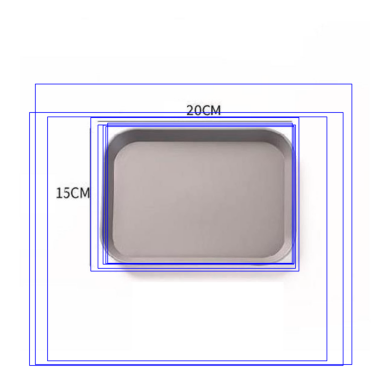

In [24]:
import torch
import cv2
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt


# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to detect objects and return bounding boxes and image
def detect_objects(image_path):
    # Load the image and convert it to RGB
    image = Image.open(image_path).convert("RGB")
    
    # Apply necessary transforms (resize, to tensor, normalize)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image)
    
    # Perform object detection
    with torch.no_grad():
        predictions = model([image_tensor])
    
    # Extract bounding boxes
    boxes = predictions[0]['boxes'].cpu().numpy()
    
    return boxes, image

# Function to visualize regions of interest (ROIs)
def visualize_rois(image, boxes):
    # Convert the PIL image to a NumPy array
    image_np = np.array(image)
    
    # Loop through the bounding boxes and draw them on the image
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        # Draw rectangle around the detected object
        cv2.rectangle(image_np, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red color
    
    # Convert the image back to RGB (OpenCV loads in BGR)
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
image_path = 'sample_images/41-NCxNuBxL.jpg'
boxes, image = detect_objects(image_path)  # Get bounding boxes and the image
visualize_rois(image, boxes)  # Visualize the ROIs on the image



In [25]:
import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import models, transforms
from torchvision.ops import nms
import pytesseract

# Helper function to ensure the directory exists
def ensure_directory_exists(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist. Creating it.")
        os.makedirs(directory)

# Function to download images from a URL
def download_image(image_url, save_path):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img.save(save_path)
        return save_path
    except Exception as e:
        print(f"Failed to download {image_url}: {str(e)}")
        return None

# Preprocess image before feeding it into RCNN
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])
    return preprocess(image).unsqueeze(0)

# Detect text using Tesseract OCR
def detect_text(image):
    gray = image.convert('L')
    ocr_text = pytesseract.image_to_string(gray)
    return ocr_text

# Function to load RCNN model
def load_rcnn_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    return model

# Function to generate predictions
def process_images_and_generate_predictions(test_csv_path, image_folder, rcnn_model):
    test_df = pd.read_csv(test_csv_path)
    predictions = []

    for idx, row in test_df.iterrows():
        image_url = row['image_link']
        image_path = os.path.join(image_folder, f"{idx}.jpg")
        
        # Download image if not already present
        if not os.path.exists(image_path):
            print(f"Downloading image: {image_url}")
            image_path = download_image(image_url, image_path)

        if image_path is None or not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            predictions.append("")
            continue

        print(f"Processing image: {image_path}")
        
        # Open and preprocess the image
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Error opening image {image_path}: {str(e)}")
            predictions.append("")
            continue
        
        # Preprocess image for RCNN
        input_tensor = preprocess_image(image)
        
        # Perform object detection
        with torch.no_grad():
            outputs = rcnn_model(input_tensor)

        # Filter boxes by confidence
        boxes = outputs[0]['boxes']
        scores = outputs[0]['scores']
        labels = outputs[0]['labels']
        selected_boxes = boxes[scores > 0.5]
        
        if selected_boxes.shape[0] > 0:
            # Apply non-maximum suppression to reduce overlap
            keep = nms(selected_boxes, scores[scores > 0.5], iou_threshold=0.3)
            selected_boxes = selected_boxes[keep]
        
        # Perform OCR on detected regions
        detected_text = ""
        for box in selected_boxes:
            x1, y1, x2, y2 = box.int().tolist()
            region = image.crop((x1, y1, x2, y2))
            ocr_result = detect_text(region)
            detected_text += ocr_result.strip() + " "

        # Process detected text to extract the entity value
        # This can be improved with specific text cleaning and formatting logic
        predictions.append(detected_text.strip())

    return predictions

# Function to generate the output CSV
def generate_output_csv(test_csv_path, output_csv_path, predictions):
    test_df = pd.read_csv(test_csv_path)
    output_rows = []

    for idx, prediction in enumerate(predictions):
        output_rows.append({
            'index': test_df.loc[idx, 'index'],
            'prediction': prediction
        })

    # Ensure the directory exists before saving
    ensure_directory_exists(output_csv_path)
    
    # Create the output DataFrame and save to CSV
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv(output_csv_path, index=False)

    print(f"Output saved to {output_csv_path}")

# Example usage
if __name__ == "__main__":
    test_csv_path = "dataset/sample_test.csv"         # Path to the test CSV file
    image_folder = "sample_images/" # Folder where images will be downloaded
    output_csv_path = "dataset/output.csv"     # Path to the output CSV file

    # Load the pre-trained RCNN model
    rcnn_model = load_rcnn_model()

    # Generate predictions and save them to a CSV file
    predictions = process_images_and_generate_predictions(test_csv_path, image_folder, rcnn_model)
    generate_output_csv(test_csv_path, output_csv_path, predictions)



Processing image: sample_images/0.jpg
Processing image: sample_images/1.jpg
Processing image: sample_images/2.jpg
Processing image: sample_images/3.jpg
Processing image: sample_images/4.jpg
Processing image: sample_images/5.jpg
Processing image: sample_images/6.jpg
Processing image: sample_images/7.jpg
Processing image: sample_images/8.jpg
Processing image: sample_images/9.jpg
Processing image: sample_images/10.jpg
Processing image: sample_images/11.jpg
Processing image: sample_images/12.jpg
Processing image: sample_images/13.jpg
Processing image: sample_images/14.jpg
Processing image: sample_images/15.jpg
Processing image: sample_images/16.jpg
Processing image: sample_images/17.jpg
Processing image: sample_images/18.jpg
Processing image: sample_images/19.jpg
Processing image: sample_images/20.jpg
Processing image: sample_images/21.jpg
Processing image: sample_images/22.jpg
Processing image: sample_images/23.jpg
Processing image: sample_images/24.jpg
Processing image: sample_images/25.

In [26]:
import pandas as pd
import re

# Load the CSV file
input_file = "dataset/output.csv"  # Replace with your file path
df = pd.read_csv(input_file)

# Allowed units (for example, you can update this list if needed)
allowed_units = ["centimetre", "inch", "millimetre", "pound", "gram", "kilogram", "ounce"]

# Function to clean the predictions
def clean_prediction(pred):
    # Check if the prediction is a valid "x unit" format (e.g., "20.0 centimetre")
    if isinstance(pred, str):
        match = re.match(r"^([0-9]*\.?[0-9]+) (\w+)$", pred.strip())
        if match:
            value, unit = match.groups()
            # Ensure the unit is allowed
            if unit in allowed_units:
                return f"{value} {unit}"
    # Return an empty string if no valid prediction
    return ""

# Apply the cleaning function to the 'prediction' column
df['prediction'] = df['prediction'].apply(clean_prediction)

# Save the cleaned output to a new CSV file
output_file = "corrected_output.csv"
df.to_csv(output_file, index=False)

print(f"Corrected file saved to {output_file}")


Corrected file saved to corrected_output.csv


In [27]:
for index, prediction in enumerate(predictions):
    print(f"Index {index}: Prediction {prediction}")


Index 0: Prediction 
Index 1: Prediction 
Index 2: Prediction 
Index 3: Prediction 
Index 4: Prediction 
Index 5: Prediction 
Index 6: Prediction 
Index 7: Prediction 
Index 8: Prediction XR

Reversib'
side & gr

Sturdy:

a —
Index 9: Prediction 
Index 10: Prediction 
Index 11: Prediction 
Index 12: Prediction 
Index 13: Prediction 
Index 14: Prediction 
Index 15: Prediction 
Index 16: Prediction 
Index 17: Prediction 
Index 18: Prediction 
Index 19: Prediction 
Index 20: Prediction 
Index 21: Prediction 
Index 22: Prediction 
Index 23: Prediction 
Index 24: Prediction 
Index 25: Prediction 
Index 26: Prediction 
Index 27: Prediction 
Index 28: Prediction 
Index 29: Prediction 
Index 30: Prediction 
Index 31: Prediction 
Index 32: Prediction 
Index 33: Prediction 
Index 34: Prediction Foam cushion for
comfort and support

Toggle and loop secures
cushion from sliding
Index 35: Prediction 
Index 36: Prediction 
Index 37: Prediction 
Index 38: Prediction 
Index 39: Prediction 
Index 40: P

In [28]:
import csv

with open("corrected_output.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["index", "prediction"])
    for index, prediction in enumerate(predictions):
        writer.writerow([index, prediction if prediction else ""])


In [45]:
import os
import re
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import pytesseract

# Allowed units
allowed_units = {
    "cm": "centimetre",
    "mm": "millimetre",
    "inch": "inch",
    "g": "gram",
    "kg": "kilogram",
    "oz": "ounce",
    "l": "litre",
    "ml": "millilitre"
}

# Download image from URL
def download_image(image_url, save_path):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img.save(save_path)
        return save_path
    except Exception as e:
        print(f"Error downloading image: {str(e)}")
        return None

# Preprocess image for OCR (convert to grayscale)
def preprocess_image(image):
    gray = image.convert('L')  # Convert to grayscale
    return gray

# Detect text using Tesseract OCR
def detect_text(image):
    processed_image = preprocess_image(image)
    ocr_text = pytesseract.image_to_string(processed_image, config='--psm 6')
    return ocr_text

# Clean detected OCR text
def clean_ocr_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s\.\,]', '', text)
    return cleaned_text.strip().lower()

# Extract number and unit using regex
def extract_number_and_unit(text):
    pattern = r'(\d+\.?\d*)\s*([a-zA-Z]+)'  # Matches numbers and units
    matches = re.findall(pattern, text)

    for match in matches:
        number, unit = match
        unit = unit.lower()

        # Check if unit is in allowed units, and map to correct format
        if unit in allowed_units:
            return f"{float(number)} {allowed_units[unit]}"
        elif unit in allowed_units.values():  # If it's already in the full form
            return f"{float(number)} {unit}"

    return ""  # Return empty if no valid match

# Process images and generate predictions using OCR only
def process_images_and_generate_predictions(test_csv_path, image_folder):
    test_df = pd.read_csv(test_csv_path)
    predictions = []

    for idx, row in test_df.iterrows():
        image_url = row['image_link']
        image_path = os.path.join(image_folder, f"{idx}.jpg")
        
        # Download image if not already present
        if not os.path.exists(image_path):
            image_path = download_image(image_url, image_path)

        if image_path is None or not os.path.exists(image_path):
            predictions.append("")
            continue

        print(f"Processing image {idx}: {image_path}")

        # Open and preprocess the image
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Error opening image {image_path}: {str(e)}")
            predictions.append("")
            continue

        # Extract text using OCR
        ocr_result = detect_text(image)
        cleaned_text = clean_ocr_text(ocr_result)

        # Extract number and unit
        prediction = extract_number_and_unit(cleaned_text)
        predictions.append(prediction if prediction else "")

    return predictions

# Generate the output CSV
def generate_output_csv(test_csv_path, output_csv_path, predictions):
    test_df = pd.read_csv(test_csv_path)
    output_rows = []

    for idx, prediction in enumerate(predictions):
        output_rows.append({
            'index': test_df.loc[idx, 'index'],
            'prediction': prediction
        })

    output_df = pd.DataFrame(output_rows)
    output_df.to_csv(output_csv_path, index=False)
    print(f"Output saved to {output_csv_path}")

# Example usage
if __name__ == "__main__":
    test_csv_path = "dataset/sample_test.csv"  # Path to the test CSV file
    image_folder = "sample_images/"            # Folder where images will be downloaded
    output_csv_path = "dataset/output_final.csv"  # Path to the output CSV file

    # Generate predictions using OCR
    predictions = process_images_and_generate_predictions(test_csv_path, image_folder)
    generate_output_csv(test_csv_path, output_csv_path, predictions)


Processing image 0: sample_images/0.jpg
Processing image 1: sample_images/1.jpg
Processing image 2: sample_images/2.jpg
Processing image 3: sample_images/3.jpg
Processing image 4: sample_images/4.jpg
Processing image 5: sample_images/5.jpg
Processing image 6: sample_images/6.jpg
Processing image 7: sample_images/7.jpg
Processing image 8: sample_images/8.jpg
Processing image 9: sample_images/9.jpg
Processing image 10: sample_images/10.jpg
Processing image 11: sample_images/11.jpg
Processing image 12: sample_images/12.jpg
Processing image 13: sample_images/13.jpg
Processing image 14: sample_images/14.jpg
Processing image 15: sample_images/15.jpg
Processing image 16: sample_images/16.jpg
Processing image 17: sample_images/17.jpg
Processing image 18: sample_images/18.jpg
Processing image 19: sample_images/19.jpg
Processing image 20: sample_images/20.jpg
Processing image 21: sample_images/21.jpg
Processing image 22: sample_images/22.jpg
Processing image 23: sample_images/23.jpg
Processing i

In [51]:
!python sanity.py --test_filename dataset/sample_test.csv --output_filename dataset/output_final.csv



Parsing successfull for file: dataset/output_final.csv


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Load the ground truth data (train.csv)
ground_truth = pd.read_csv("dataset/train.csv")

# Create a train-test split (80% training, 20% validation)
train_data, val_data = train_test_split(ground_truth, test_size=0.2, random_state=42)

# Simulate the predictions (for now, we'll assume predictions are equal to the ground truth)
# You should replace this with actual predictions from your model
val_data['prediction'] = val_data['entity_value']

# Normalize text for F1 score calculation (remove extra spaces, lowercasing)
def normalize_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    return str(text).strip().lower()  # Convert to string, strip spaces, and convert to lowercase

# Normalize ground truth and predictions
val_data['entity_value'] = val_data['entity_value'].apply(normalize_text)
val_data['prediction'] = val_data['prediction'].apply(normalize_text)

# Calculate F1 score using the validation set
f1 = f1_score(val_data['entity_value'], val_data['prediction'], average='micro')

print(f"F1 Score: {f1:.4f}")



F1 Score: 1.0000
